<a href="https://colab.research.google.com/github/pdoren/analisis-estadistico-con-Python-G105/blob/main/Desaf%C3%ADo_Preparacion_de_datos_y_graficos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Desafío - Preparación de datos y gráficos

**Nombre**: Pablo Saavedra <br />
**Curso**: Análisis estadístico con Python (G105)


---



## Carga de librerías y definición de funciones de apoyo

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.impute import SimpleImputer

imp_num = SimpleImputer(strategy="median") # Se carga la clase para procesar las imputaciones

pd.options.display.float_format = "{:,.2f}".format   # Visualizar 2 decimales

def print_outliers(_df: pd.DataFrame, _cols: list,
                 _k: float=1.5, col_index: str='Country'):
  print('Outliers:')
  for col in _cols:
    q1, q3 = _df[col].quantile([.25, .75])
    iqr = q3 - q1
    low, high = q1 - _k * iqr, q3 + _k * iqr
    mask_out = (_df[col] < low) | (_df[col] > high)
    if mask_out.any():
      print(col)
      print(_df[mask_out][[col_index, col]])

def get_outliers(_df: pd.DataFrame, _cols: list,
                 _k: float=1.5):
  ret = None
  for col in _cols:
    q1, q3 = _df[col].quantile([.25, .75])
    iqr = q3 - q1
    low, high = q1 - _k * iqr, q3 + _k * iqr
    mask_out = (_df[col] < low) | (_df[col] > high)
    if mask_out.any():
      if ret is None:
        ret = mask_out
      else:
        ret = ret | mask_out
  return ret

def escalado_robusto(_df: pd.DataFrame, _cols: list) -> pd.DataFrame:
  df2 = _df.copy()
  for col in _cols:
    q1 = df2[col].quantile(0.25)
    q3 = df2[col].quantile(0.75)
    iqr = q3 - q1
    df2[col] = (df2[col] - q1) / iqr
  return df2


**Comentarios**

---

**get_outliers** es una función que obtiene los valores atípicos o outliers utilizando la **regla del rango intercuartil**:

Cualquier observación $x$ que satisfaga la ecuación de abajo implica que es un valor atípico o outliers.

$$ |x| > k \cdot IQR$$

Donde:
- $Q_1$, primer cuartil (25 % de los datos por debajo).
- $Q_3$, tercer cuartil (75 % de los datos por debajo).
- Contante $k$:
  - $k = 1.5$ se obtienen valores atípicos.
  - $k = 3.0$ se obtienen valores extremos.
- $IQR = (Q_3 - Q_1)$ rango intercuartílico.

---

**escalado_robusto** es una función que permite normalizar los datos las columnas que se entreguen como parámetro. Este normalización se utiliza en los casos con datos con outliers. Para la normalización se utiliza la siguiente formula:

$$ x' = \frac{x - Q_1}{IQR} = \frac{x - Q_1}{Q_3 - Q_1}$$

Donde:
- $Q_1$, primer cuartil (25 % de los datos por debajo).
- $Q_3$, tercer cuartil (75 % de los datos por debajo).
- $IQR = (Q_3 - Q_1)$ rango intercuartílico.

---

## 1. Carga de Datos
Carga los datos y genera un dataFrame que excluya las columnas correspondientes a la abreviatura del país, código de llamada, capital, código de moneda, ciudad más grande, lenguaje oficial, latitud y longitud. Considerando estos datos, realiza una inspección inicial sobre ellos, considerando gráficos. Concluye.

---

Carga de los datos con Pandas:

In [2]:
df_orig = pd.read_csv('/content/drive/MyDrive/world-data-2023.csv')

# Borrar columnas
df_orig = df_orig.drop(['Abbreviation', 'Calling Code', 'Capital/Major City', 'Currency-Code',
                        'Largest city', 'Official language', 'Latitude', 'Longitude'], axis=1)
df = df_orig

# Se eliminan duplicados si existen
df = df.drop_duplicates()

# Convertir campos a números reales y validar porcentajes
for campo in df.columns:
  if campo != 'Country':
    if df[campo].dtype == 'string' or df[campo].dtype == 'object':
      df[campo] = df[campo].str.replace(r'[,\$%]', '', regex=True).astype(float)

# Corregir algunos errores en el nombre de las columnas
df.columns = df.columns.str.replace('\n', '')
df.columns = df.columns.str.replace('Land( %', 'Land (%')
df.columns = df.columns.str.replace('y(P', 'y (P')
df.columns = df.columns.str.replace('Area(K', 'Area (K')


> **Nota**: previamente se observó que los registros de algunas columnas contenian caracteres que no permitian convertir los registros a números. Se eliminaron esos caracteres y se realizó la conversión para poder trabajar con ellos.

Al revisar los nombres de los países se encuentra un error en uno de sus nombres

In [3]:
df['Country'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'The Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
       'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'Brunei', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Ivory Coast',
       'Cape Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Comoros', 'Republic of the Congo', 'Costa Rica', 'Croatia',
       'Cuba', 'Cyprus', 'Czech Republic',
       'Democratic Republic of the Congo', 'Denmark', 'Djibouti',
       'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon',
       'The Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Grenada',
       'Guatemal

In [4]:
df[df['Country'] == 'S�����������']

,Country,Density (P/Km2),Agricultural Land (%),Land Area (Km2),Armed Forces size,Birth Rate,Co2-Emissions,CPI,CPI Change (%),Fertility Rate,...,Maternal mortality ratio,Minimum wage,Out of pocket health expenditure,Physicians per thousand,Population,Population: Labor force participation (%),Tax revenue (%),Total tax rate,Unemployment rate,Urban_population
150,S�����������,228.00,50.70,964.00,"1,000.00",31.54,121.00,185.09,7.90,4.32,...,130.00,NaN,11.70,0.05,"215,056.00",57.80,14.60,37.00,13.37,"158,277.00"


Se procede a eliminar

In [5]:
df = df.drop(150)

Se normalizan algunas columnas:



In [6]:
# Birth Rate:
# se cambia de Número de nacimientos por 1,000 habitantes por año a un porcentaje
df['Birth Rate'] = df['Birth Rate'] / 1000.0 * 100

# Infant Mortality:
# se cambia de Número de muertes por cada 1,000 nacidos vivos antes de cumplir
# un año de edad por porcentaje
df['Infant mortality'] = df['Infant mortality'] / 1000.0 * 100

# Maternal Mortality Ratio:
# Número de muertes maternas por cada 100,000 nacidos vivos por porcentaje
df['Maternal mortality ratio'] = df['Maternal mortality ratio'] / 100000.0 * 100

## 1.2 Gráficos Datos

> Plotear el histograma de los datos:

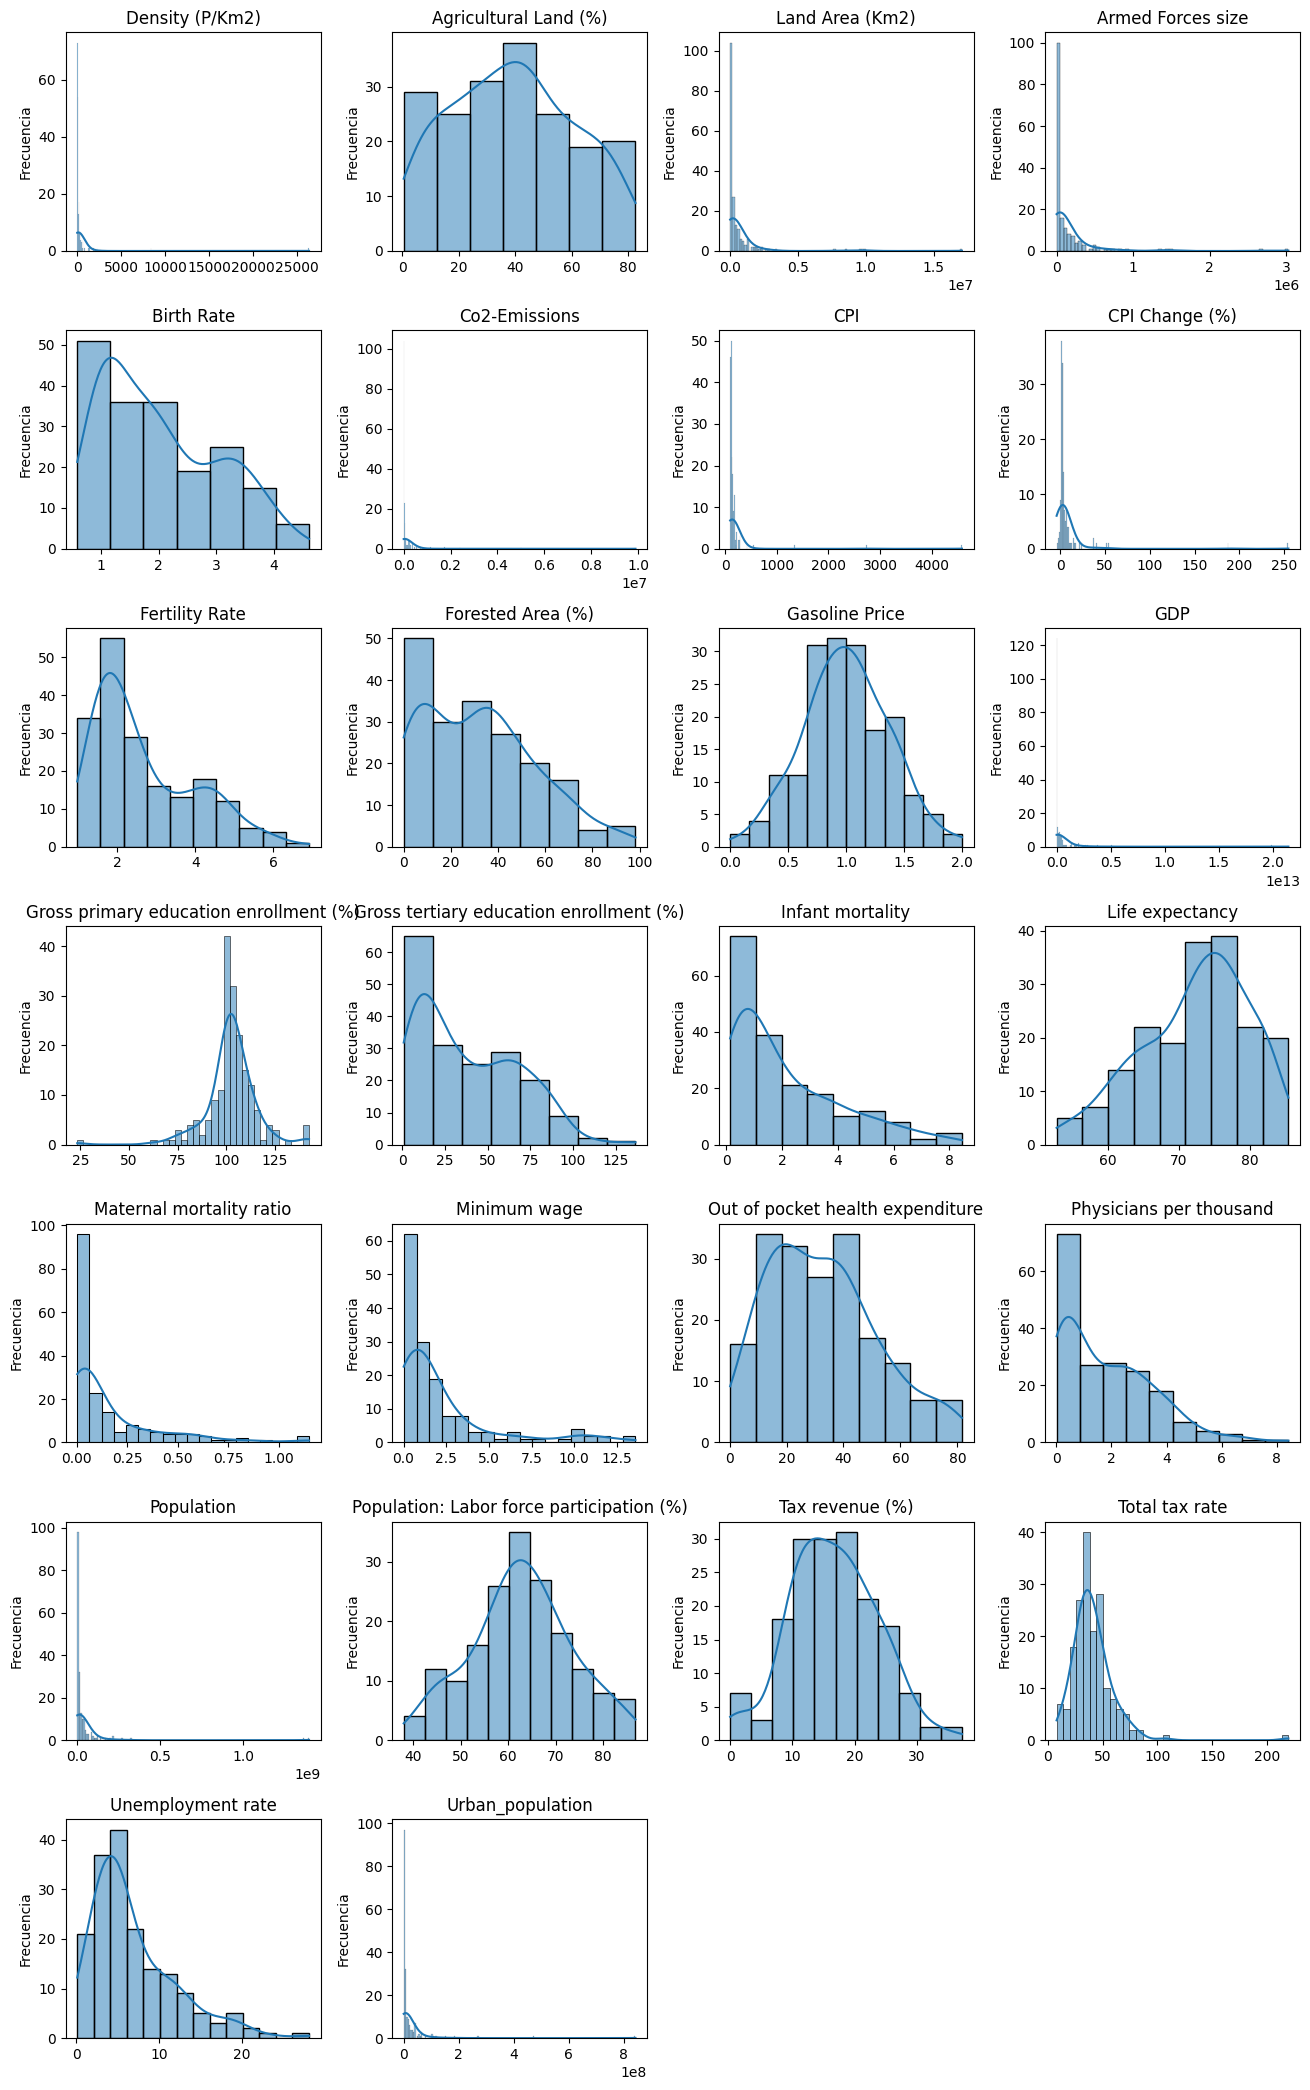

In [7]:
cols = df.select_dtypes(include="number").columns # seleccionar datos númericos

# Ajustes para plot
bins      = 'fd'     # nº de barras por histograma, Freedman-Diaconis
add_kde   = True     # curva KDE encima del histograma
wrap_cols = 4        # nº de subgráficas por fila
fig_h     = 3        # alto (pulgadas) de cada faceta
fig_aspect= 1.1      # ancho ≈ alto*aspect

# Rejilla
n_plots   = len(cols)
n_rows    = math.ceil(n_plots / wrap_cols)
fig_w     = wrap_cols * fig_h * fig_aspect

fig, axes = plt.subplots(n_rows, wrap_cols,
                         figsize=(fig_w, n_rows * fig_h),
                         sharex=False, sharey=False)

axes = axes.ravel()

# Plot Histograma
for i, col in enumerate(cols):
    ax = axes[i]
    sns.histplot(df[col], bins=bins, kde=add_kde, ax=ax)
    ax.set_title(col)
    ax.set_xlabel("")     # deja limpio o personaliza
    ax.set_ylabel("Frecuencia")

# Eliminar Celdas Vacias
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Se puede concluir del gráfico de histograma lo siguiente:

- Los datos de las columnas: Density, Land Area, Armed Forces Size, Co2 Emissions, CPI, CPI Change, GDP, Maternal Mortality, Population y Urban Population estan muy concentrados.
- Muy probablemente las columnas anteriores contengan datos outliers o extremos

Plotear Boxplot de los datos:

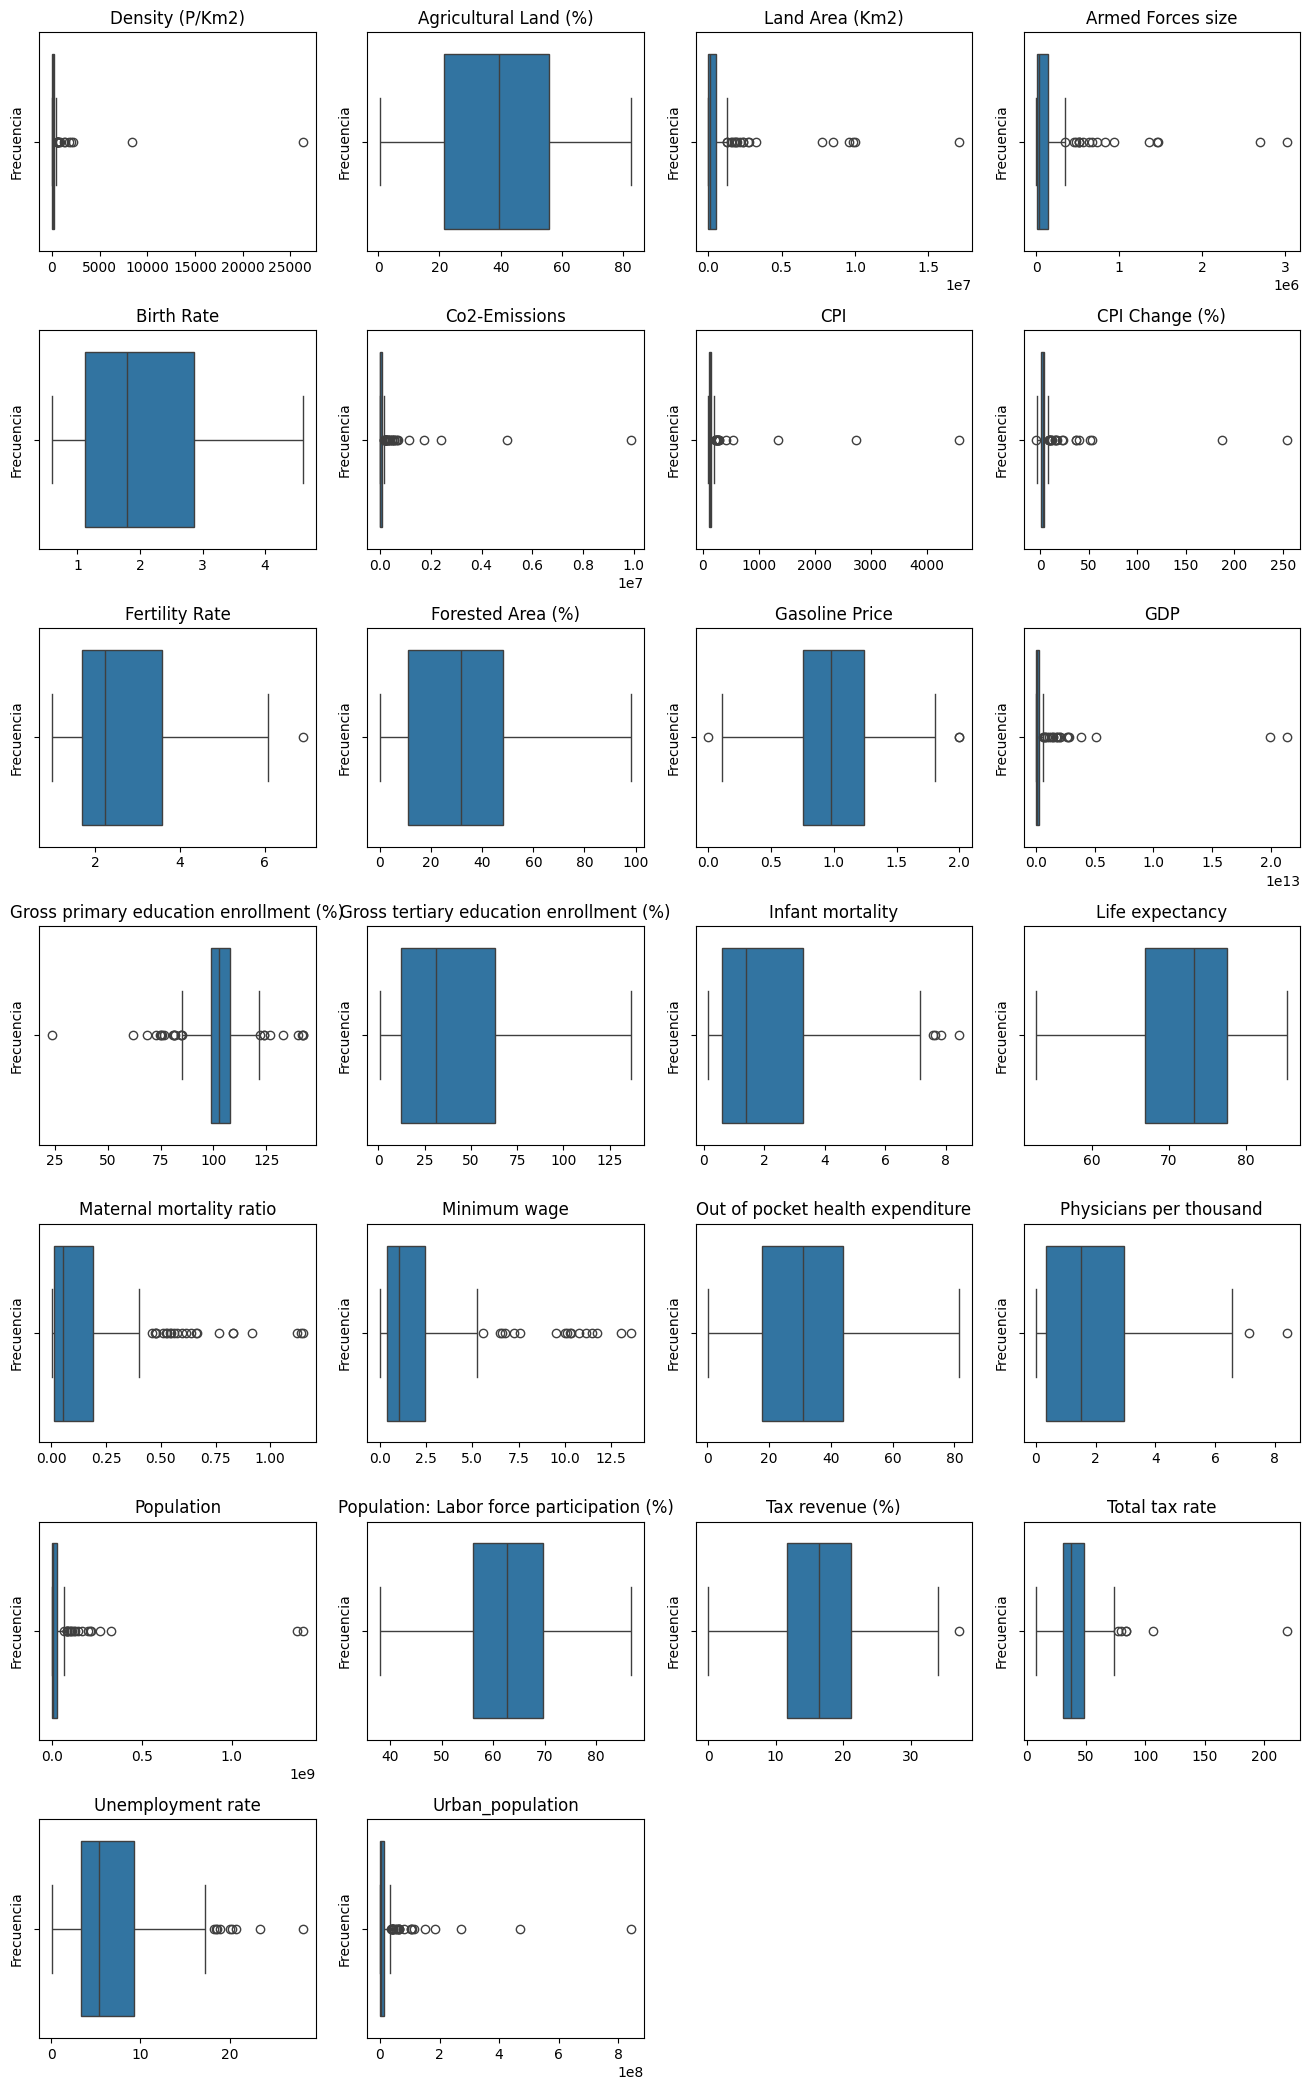

In [8]:
fig, axes = plt.subplots(n_rows, wrap_cols,
                         figsize=(fig_w, n_rows * fig_h),
                         sharex=False, sharey=False)

axes = axes.ravel()

# Plot Boxplot
for i, col in enumerate(cols):
    ax = axes[i]
    sns.boxplot(x=df[col], ax=ax)
    ax.set_title(col)
    ax.set_xlabel("")     # deja limpio o personaliza
    ax.set_ylabel("Frecuencia")

# Eliminar Celdas Vacias
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Se puede concluir del gráfico de boxplot lo siguiente:

- La confirmación de varias columnas con outliers
- Solo las columnas Agricultura Land, Birth rate, Forest Area, Gross tertiary education enrollment, Life expectancy, Out of pocket health y Population Labor force participation no contienen outliers



## 2. Correlación
De las variables codificadas numéricamente, ¿hay pares de ellas en la que parezca haber correlación? ¿Para cuál(es) de ellas se observa más claramente?

---

## 2.1 Graficar correlación
Primero para obtener la correlación entre las diferentes columnas se utiliza el método corr del dataframe de Pandas. Luego se utiliza la función heatmap de Seaborn en donde se entrega como parámetro la correlación obtenida en el paso anterior.

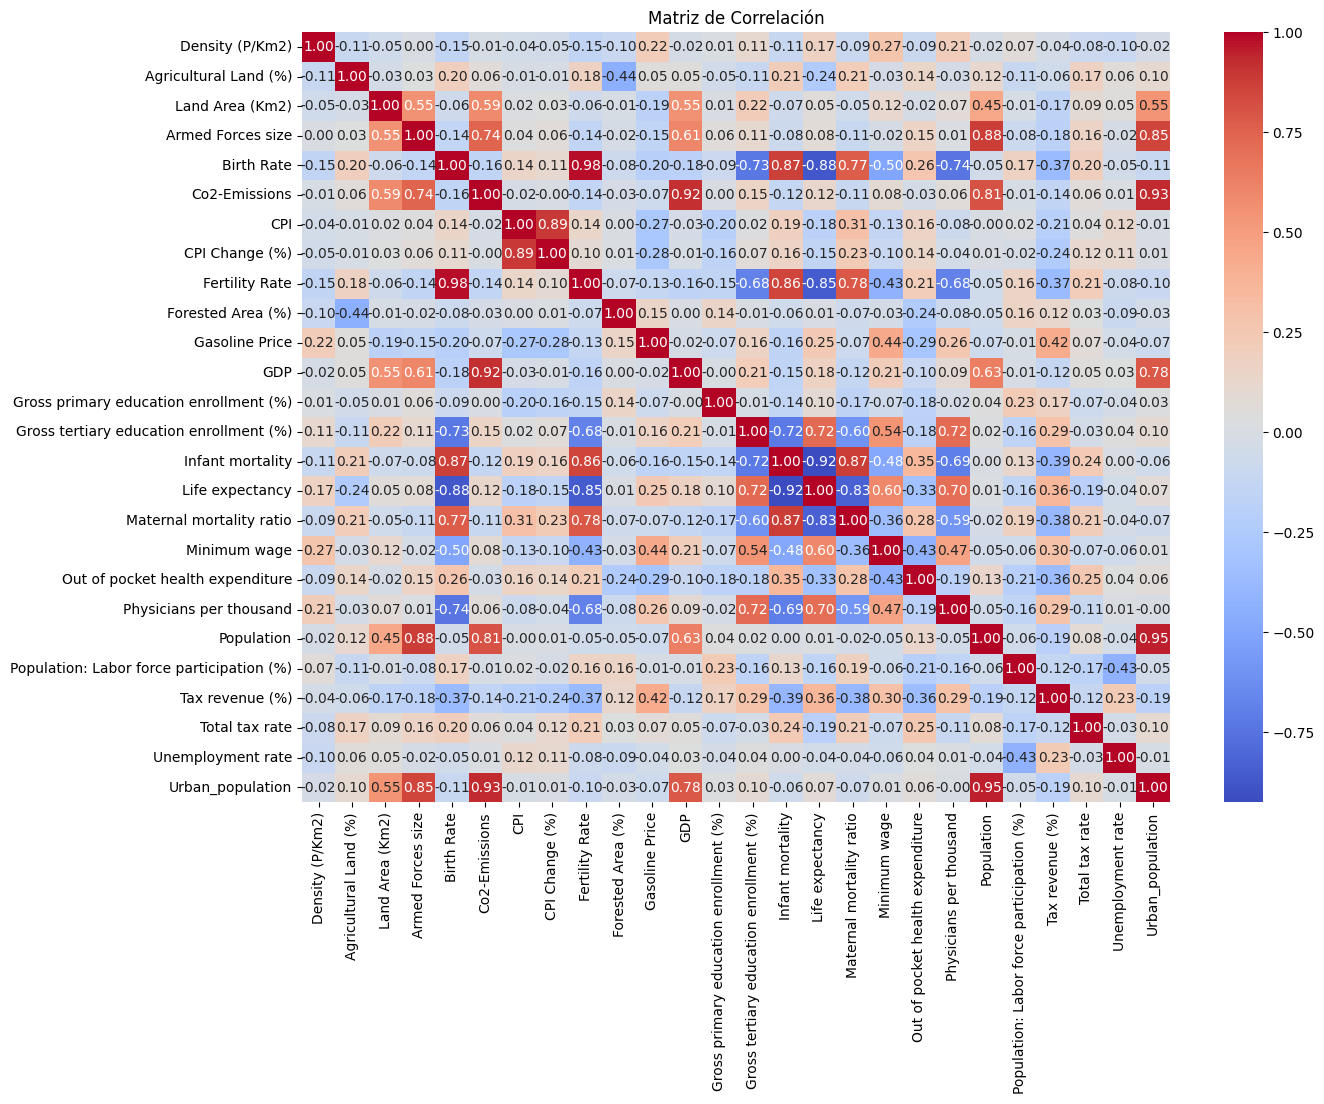

In [9]:
matriz_correlacion = df.select_dtypes(include="number").corr()

plt.figure(figsize=(14, 10))
sns.heatmap(matriz_correlacion, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlación")
plt.show()

Del gráfico anterior se puede obtener los pares de mayor correlación, es decir, correlación mayor a 0.9 o menor a -0.9:

- Birth rate y Fertility rate (0.98)
- C2-Emissions y GDP (0.92)
- C2-Emissions y Urban Population (0.93)
- Population y Urban Population (0.95)
- Life expactancy y Infant mnortality (-0.92)

Tambien es posible generar un gráfico que generé clusteres o conjuntos a partir de los de datos de las columnas que tienen una alta correlación.

<Figure size 1400x1000 with 0 Axes>

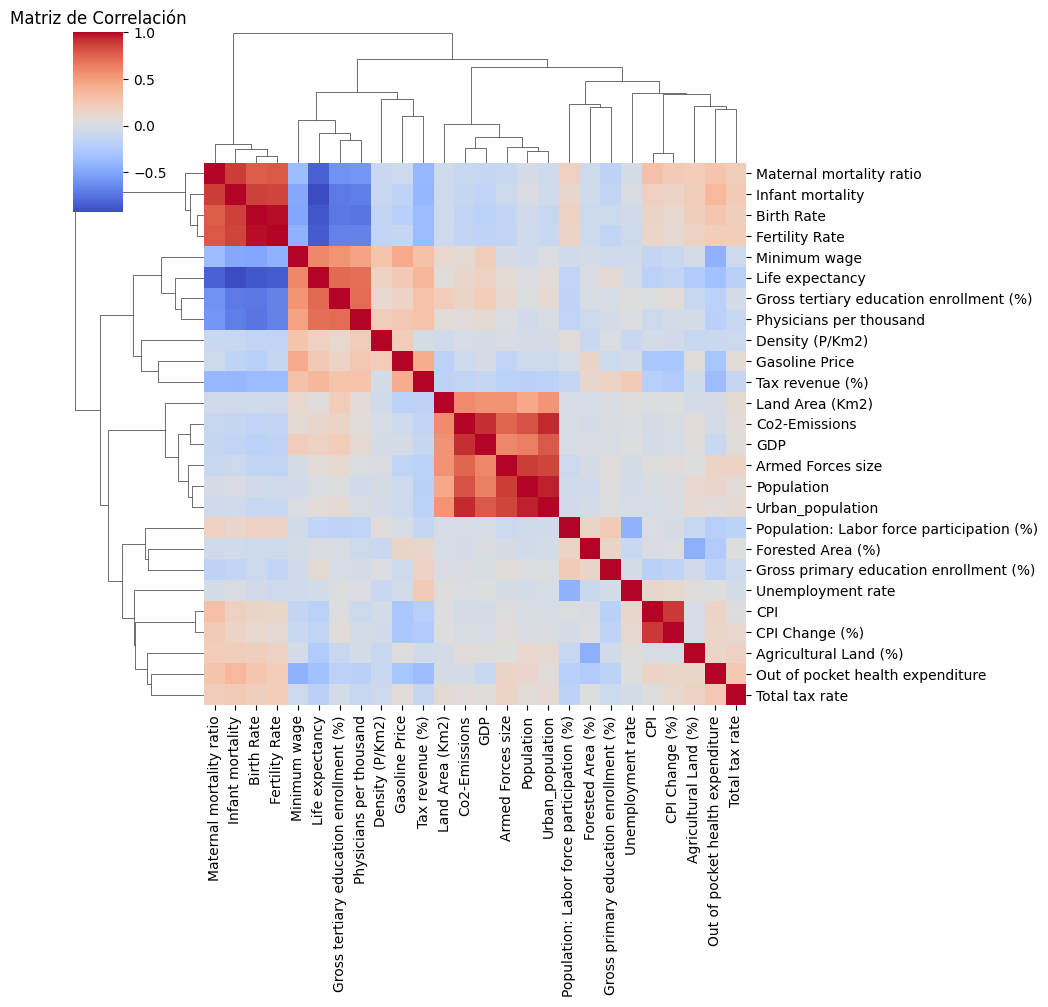

In [10]:
plt.figure(figsize=(14, 10))
sns.clustermap(matriz_correlacion, cmap="coolwarm")
plt.title("Matriz de Correlación")
plt.show()

En el gráfico de correlación anterior se muestran los valores con mayor correlación (valores cenrcanos a 1) en rojo y de correlación negativa alta (valor cercanos a -1) en azul.

Del gráfico podemos concluir:

- Se generan al menos 4 clusteres donde existe una alta correlación:
  - Cluster 1:
    - Maternal mortality ratio
    - Infant mortality
    - Birth Rate
    - Fertility Rate
  - Cluster 2:
    - Life expectancy
    - Gross tertiary education enrollment (%)
    - Physicians per thousand
  - Cluster 3:
    - Land Area (Km2)
    - Co2-Emissions
    - GDP
    - Armed Forces size
    - Population
    - Urban population
  - Cluster 4:
    - CPI
    - CPI Change (%)
- En el cluster 1 las columnas se relacinan por datos de nacimiento
- En el cluster 2 las columnas se relacionan por educación. También se considera la espectativa de vida (Life expectancy) que se puede relacionar con la cantidad de médicos (Physicians per thousand)
- En el cluster 3 las columnas se relacionan por la cantidad de personas en cada país.
- En el cluster 4 las columnas se relacionan porque ambas son medidas o indicadores de inflación  
- Entre el cluster 1 y 2 existe una correlación negativa


## 3. Variables con mayor Correlación
Considera los dos pares de variables anteriores y elimina en cada caso los faltantes y atípicos. Justifica en cada caso tu procedimiento.

---

Los casos que se utilizaran en este análisis serán:

1. **Caso 1**: Birth Rate vs Fertility Rate
2. **Caso 2**: Life expectancy vs Infant mortality

Donde sus correlaciones son las que aperecen en el siguiente gráfico:

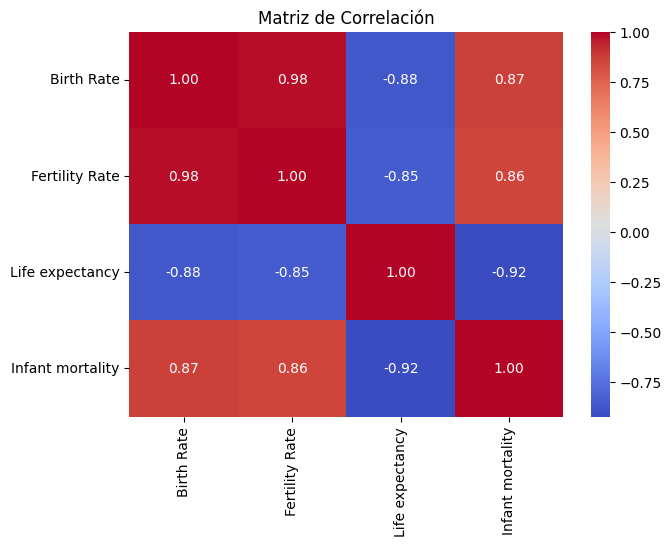

In [11]:
matriz_correlacion_mayor_v1 = df[['Birth Rate', 'Fertility Rate', 'Life expectancy', 'Infant mortality']].corr()

plt.figure(figsize=(7, 5))
sns.heatmap(matriz_correlacion_mayor_v1, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlación")
plt.show()

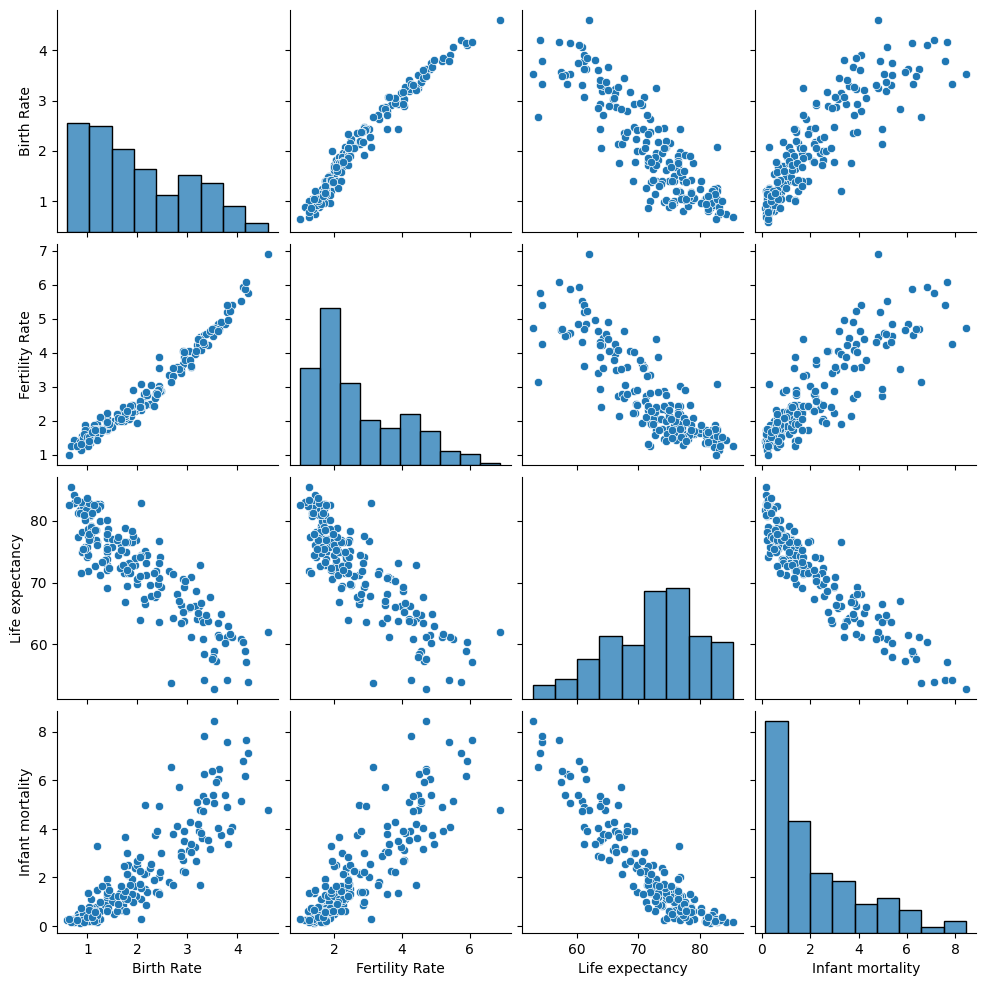

In [12]:
sns.pairplot(df.select_dtypes(include="number")[['Birth Rate', 'Fertility Rate', 'Life expectancy', 'Infant mortality']])
plt.show()

## 3.1 Caso 1: Birth rate y Fertility rate

La razón de nacimientos y el promedio de nacimientos de hijos en una mujer tienen una alta correlación (0.98) por razones que resultan obvias, existe una relación directa (nacimientos - mujeres). Mientras más nacimientos el número de hijos nacidos aumenta en promedio por mujer aumenta.

Para el análisis se evaluaran los outliers y luego los valores nulos.

### 3.1.1 Caso 1: Outliers

Para los outliers primero se utilizará el gráfico boxplot para identificar la existencia de estos valores atípicos:

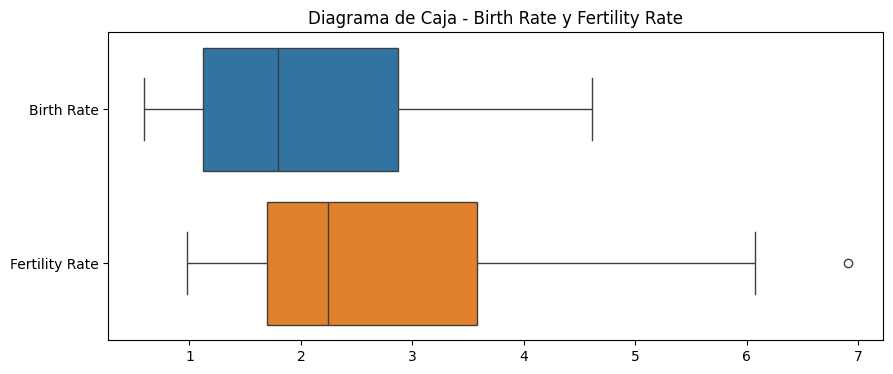

In [13]:
cols = ['Birth Rate', 'Fertility Rate']
plt.figure(figsize=(10,4))
sns.boxplot(data=df[cols], orient='h')
plt.title("Diagrama de Caja - Birth Rate y Fertility Rate")
plt.show()

En el gráfico anterior se observa la existencia de un outliers, para obtener la fila a la que corresponde se utiliza la función get_outliers:

In [14]:
print_outliers(df, cols)

Outliers:
Fertility Rate
    Country  Fertility Rate
125   Niger            6.91


El outliers proviene de Nigeria con una tasa de 6.91% según el criterio del rango intercuartil. Para no eliminar la fila completa se procede a imputar la media:

In [15]:
df.loc[125, 'Fertility Rate'] = df['Fertility Rate'].median()

### 3.1.2 Caso 1: Valores Nulos

Para los valores faltantes se tomará el porcentaje de nulos por columna y si es menor a 40% se inputará la media, de caso contrario se amputará (eliminar) las filas con valores nulos en las columnas procesadas. ([Link Justificación criterio 40%](https://pmc.ncbi.nlm.nih.gov/articles/PMC6293424/))

In [16]:
# Para determinar si se debe imputar o amputar los datos faltantes se obtiene el porcentaje de nulos por columna
df[cols].apply(lambda x: sum(x.isnull()), axis=0).sort_values(ascending=False) / len(df) * 100

,0
Fertility Rate,3.61
Birth Rate,3.09


Como el porcentaje de nulos de todas las columnas es menor al 40% se procede a imputar la media en los datos faltantes de cada columna.

Datos estadísticos antes de la imputación:

In [17]:
df[cols].describe()

,Birth Rate,Fertility Rate
count,188.00,187.00
mean,2.02,2.66
std,0.99,1.24
min,0.59,0.98
25%,1.12,1.70
50%,1.79,2.24
75%,2.87,3.56
max,4.61,6.07


Imputación y nuevos datos estadísticos:

In [18]:
df[cols] = imp_num.fit_transform(df[cols]) # Se imputa la media
df[cols].describe()

,Birth Rate,Fertility Rate
count,194.00,194.00
mean,2.01,2.65
std,0.98,1.22
min,0.59,0.98
25%,1.14,1.71
50%,1.79,2.24
75%,2.82,3.55
max,4.61,6.07


Las estadísticas no cambiaron mayormente (solo una centésima en algunos valores).

## 3.2 Caso 2: Life expactancy y Infant mortality

La esperanza de vida y la mortalidad infantil tienen una alta correlación negativa (-0.92), es decir, mientras una sube la otra baja. Su relación es negativa: vida y muerte. La mortalidad infantil indica la razón de muertes antes de cumplir un año y la esperanza de vida indica la el número de años promedio que se espera que un recien nacido viva.


### 3.2.1 Caso 2: Outliers

Para los outliers primero se utilizará el gráfico boxplot para identificar la existencia de estos valores atípicos:

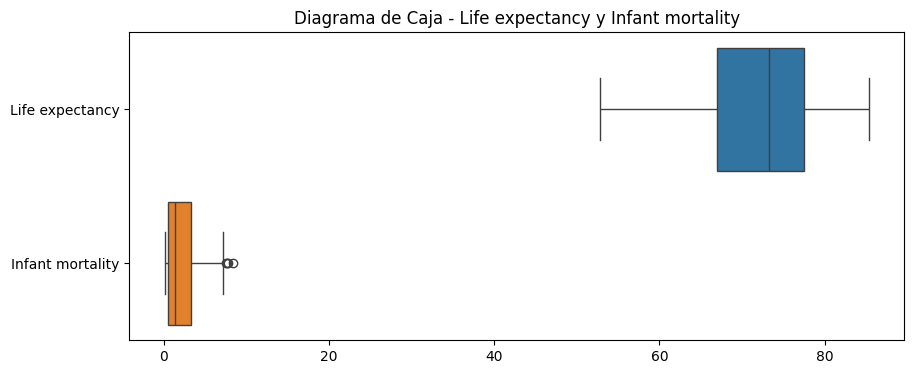

In [19]:
cols_2 = ['Life expectancy', 'Infant mortality']
plt.figure(figsize=(10,4))
sns.boxplot(data=df[cols_2], orient='h')
plt.title("Diagrama de Caja - Life expectancy y Infant mortality")
plt.show()

Aplicando la misma función anterior para obtener los outliers:

In [20]:
print_outliers(df, cols_2)

Outliers:
Infant mortality
                      Country  Infant mortality
33   Central African Republic              8.45
126                   Nigeria              7.57
155              Sierra Leone              7.85
160                   Somalia              7.66


En esta comparación se cuentran 4 outliers según el criterio de la **regla del rango intercuartil**. Para no eliminar las filas completas se procede a imputar la media:

In [21]:
for i in [33, 126, 155, 160]:
  df.loc[i, 'Infant mortality'] = df['Infant mortality'].median()

### 3.2.2 Caso 2: Valores Nulos

Aplicando el mismo criterio anterior del 40%, de nulos se procede a calcular el porcentaje:

In [22]:
# Para determinar si se debe imputar o amputar los datos faltantes se obtiene el porcentaje de nulos por columna
df[cols_2].apply(lambda x: sum(x.isnull()), axis=0).sort_values(ascending=False) / len(df) * 100

,0
Life expectancy,4.12
Infant mortality,3.09


Como el porcentaje de nulos de todas las columnas es menor al 40% se procede a imputar la media en los datos faltantes de cada columna.

Datos estadísticos antes de la imputación:

In [23]:
df[cols_2].describe()

,Life expectancy,Infant mortality
count,186.00,188.00
mean,72.29,1.99
std,7.50,1.77
min,52.80,0.14
25%,66.95,0.60
50%,73.30,1.39
75%,77.55,3.04
max,85.40,7.14


Imputación y nuevos datos estadísticos:

In [24]:
df[cols_2] = imp_num.fit_transform(df[cols_2]) # Se imputa la media
df[cols_2].describe()

,Life expectancy,Infant mortality
count,194.00,194.00
mean,72.33,1.97
std,7.35,1.74
min,52.80,0.14
25%,67.38,0.61
50%,73.30,1.39
75%,77.28,3.00
max,85.40,7.14


Las estadísticas no cambiaron mayormente (solo unas centésima en algunos valores).

## 4. Gráfico entre variables
Construye un gráfico para verificar la correlación entre estas variables, ahora con los datos preparados. Compara con lo obtenido anteriormente.

El nuevo gráfico de correlación obtenido es el siguiente:

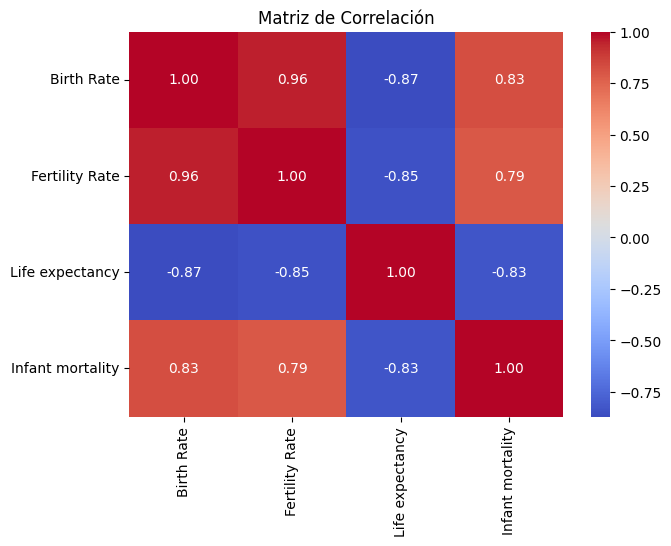

In [25]:
matriz_correlacion_mayor_v2 = df[['Birth Rate', 'Fertility Rate', 'Life expectancy', 'Infant mortality']].corr()

plt.figure(figsize=(7, 5))
sns.heatmap(matriz_correlacion_mayor_v2, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlación")
plt.show()

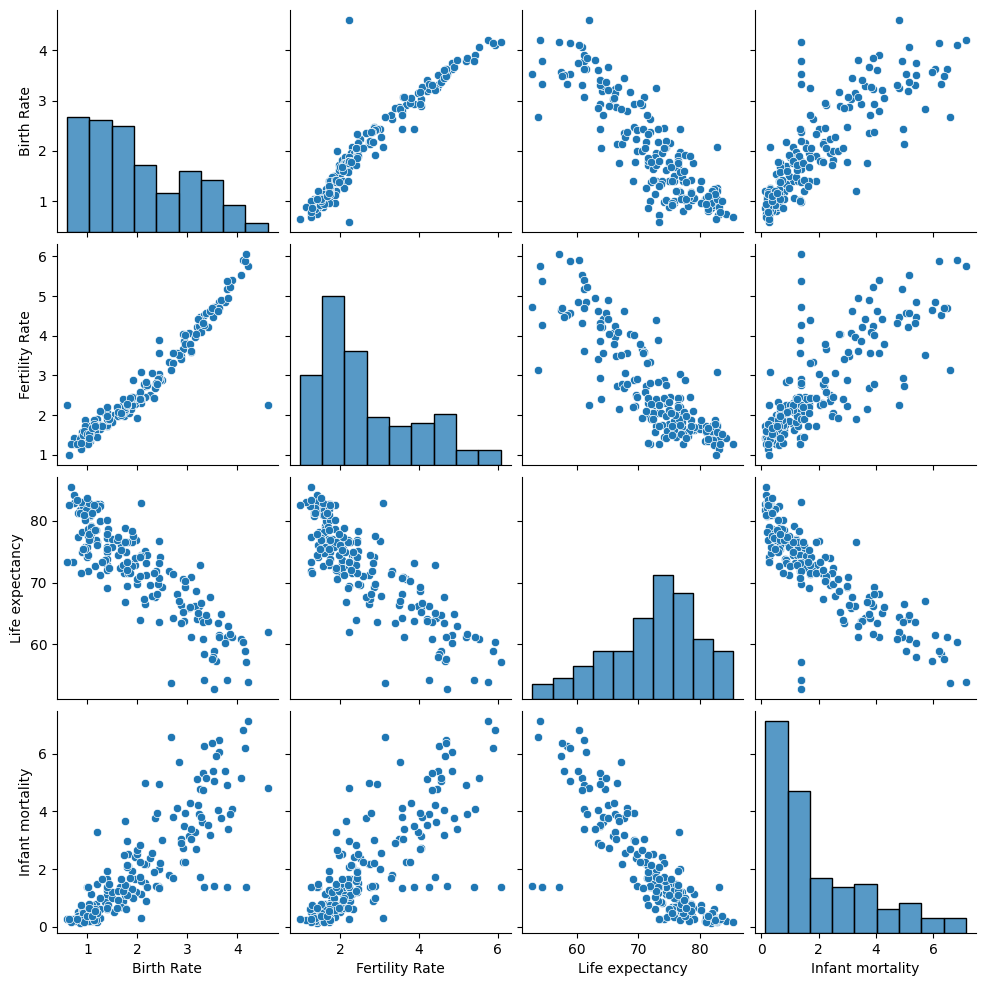

In [26]:
sns.pairplot(df[['Birth Rate', 'Fertility Rate', 'Life expectancy', 'Infant mortality']])
plt.show()

De este gráfico se puede concluir que la eliminación de los outliers no tuvo un efecto significativo (considerando que solo se obtiene 2 cifras decimales) en las correlación de los datos.

Respecto a los outliers, en el primer caso y gráficando nuevamente con boxplot no se observan outliers. Sin embargo, en el caso 2 si se observan nuevos outliers esto debido a que los datos de Infant mortality están muy centrados cerca de cero y su cola de distribución hacia la derecha es muy larga. Estos datos no serán modificados (imputación de la media).

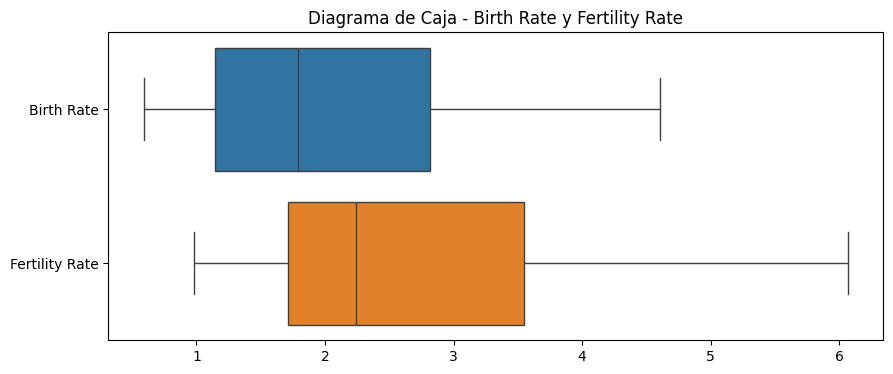

In [27]:
cols = ['Birth Rate', 'Fertility Rate']
plt.figure(figsize=(10,4))
sns.boxplot(data=df[cols], orient='h')
plt.title("Diagrama de Caja - Birth Rate y Fertility Rate")
plt.show()

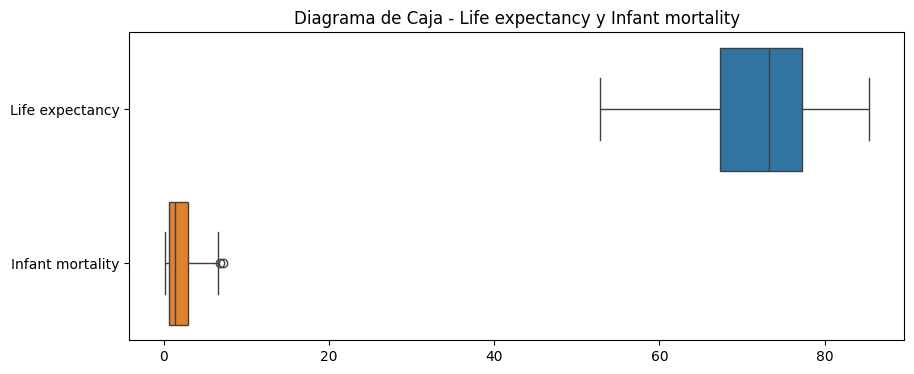

In [28]:
cols_2 = ['Life expectancy', 'Infant mortality']
plt.figure(figsize=(10,4))
sns.boxplot(data=df[cols_2], orient='h')
plt.title("Diagrama de Caja - Life expectancy y Infant mortality")
plt.show()

In [29]:
print_outliers(df, cols_2)

Outliers:
Infant mortality
                             Country  Infant mortality
34                              Chad              7.14
45  Democratic Republic of the Congo              6.82


## 5. Médicos y esperanza de vida
Realiza lo mismo para comparar la cantidad de médicos por cada mil personas y la esperanza de vida. ¿Qué puedes concluir?

---

Al calcular la correlación entre ambas variables (Cantidad de médicos y esperanza de vida) se tiene que existe una correlación positiva (0.69), lo que implica que mientras un valor sube el otro también lo hace.

Esta correlación indica que cuando la cantidad de doctores sube la experanza de vida aumenta. Esto resulta intuitivo debido a que a mayor cantidad de doctores mayor posibilidad de acceso a salud en la población y mejor esperanza de vida o posibilidad de que un recien nacido pueda vivir en promedio más años.

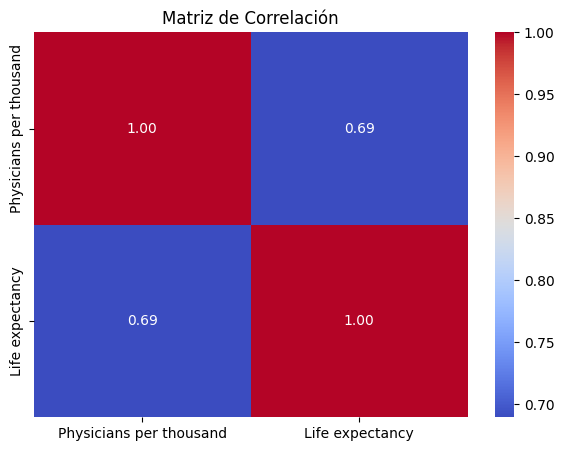

In [30]:
cols_3 = ['Physicians per thousand', 'Life expectancy']
matriz_correlacion_mayor_v3 = df[cols_3].corr()

plt.figure(figsize=(7, 5))
sns.heatmap(matriz_correlacion_mayor_v3, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlación")
plt.show()

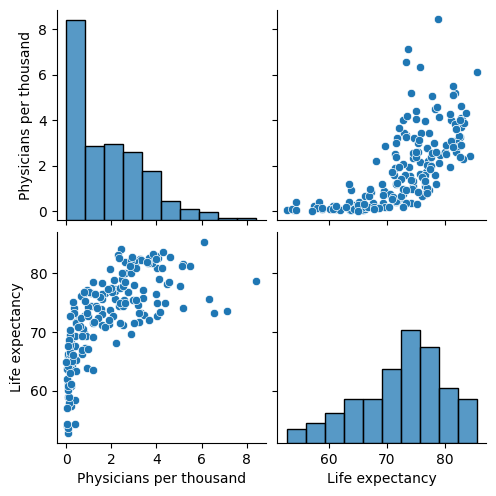

In [31]:
sns.pairplot(df[['Physicians per thousand', 'Life expectancy']])
plt.show()

## 5.1 Datos nulos
Para los datos nulos se utilizará el mismo procedimiento en seccion 3. Al revisar el porcentaje de nulos es menor al 40% se procede a imputarles la media.

In [32]:
# Para determinar si se debe imputar o amputar los datos faltantes se obtiene el porcentaje de nulos por columna
df[cols_3].apply(lambda x: sum(x.isnull()), axis=0).sort_values(ascending=False) / len(df) * 100

,0
Physicians per thousand,3.61
Life expectancy,0.00


Datos estadísticos antes de la imputación:


In [33]:
df[cols_3].describe()

,Physicians per thousand,Life expectancy
count,187.00,194.00
mean,1.85,72.33
std,1.68,7.35
min,0.01,52.80
25%,0.34,67.38
50%,1.51,73.30
75%,2.95,77.28
max,8.42,85.40


Imputación y nuevos datos estadísticos:

In [34]:
df[cols_3] = imp_num.fit_transform(df[cols_3]) # Se imputa la media
df[cols_3].describe()

,Physicians per thousand,Life expectancy
count,194.00,194.00
mean,1.84,72.33
std,1.65,7.35
min,0.01,52.80
25%,0.37,67.38
50%,1.51,73.30
75%,2.88,77.28
max,8.42,85.40


Las estadísticas no cambiaron mayormente (solo una centésima en algunos valores).

## 5.2 Outliers
Para los outliers se revisará el gráfico boxplot. En este gráfico se observan al menos 2 outliers: Cuba y Georgia. Ambos países tienen una gran cantidad de doctores respecto a la cantidad de habitantes. Además están muy lejos del promedio de 1.83 médicos por cada mil habitantes.

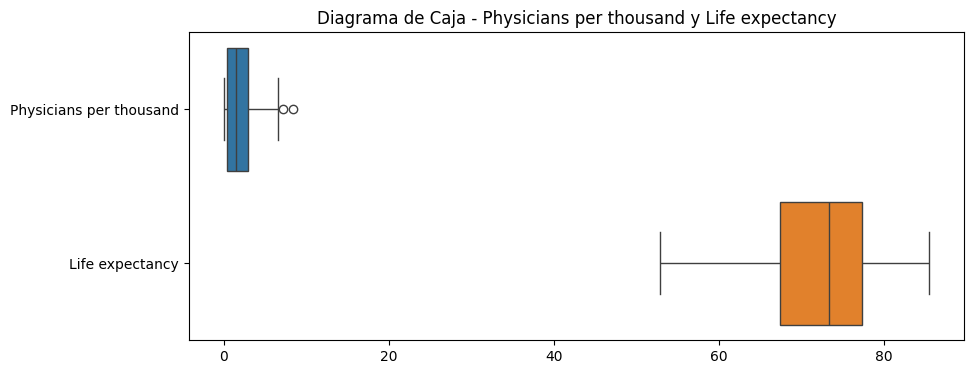

In [35]:
plt.figure(figsize=(10,4))
sns.boxplot(data=df[cols_3], orient='h')
plt.title("Diagrama de Caja - Physicians per thousand y Life expectancy")
plt.show()

In [36]:
print_outliers(df, cols_3)

Outliers:
Physicians per thousand
    Country  Physicians per thousand
42     Cuba                     8.42
63  Georgia                     7.12


Debido a que la distribución esta concentrada cerca de cero y que la imputación de la media solo generaría la nueva exstencia de nuevos casos de outliers, se decide mantener los datos.

## 6. Población países
Construye un gráfico para representar la población total de los países y su producto interno bruto. Prepara los datos y escoge el gráfico adecuado (si es necesario, limpia y/o transforma los datos). Justifica.

---

## Gráfico Población vs PIB

In [37]:
%pip install country_converter

In [38]:
import country_converter as coco

df_extra = df.copy()
df_extra['Continent'] = coco.convert(names=df['Country'], to='continent') # asignar continentes a los países
df_extra['gdp_per_capita'] = df_extra['GDP'] / df_extra['Population'] # PIB per capita

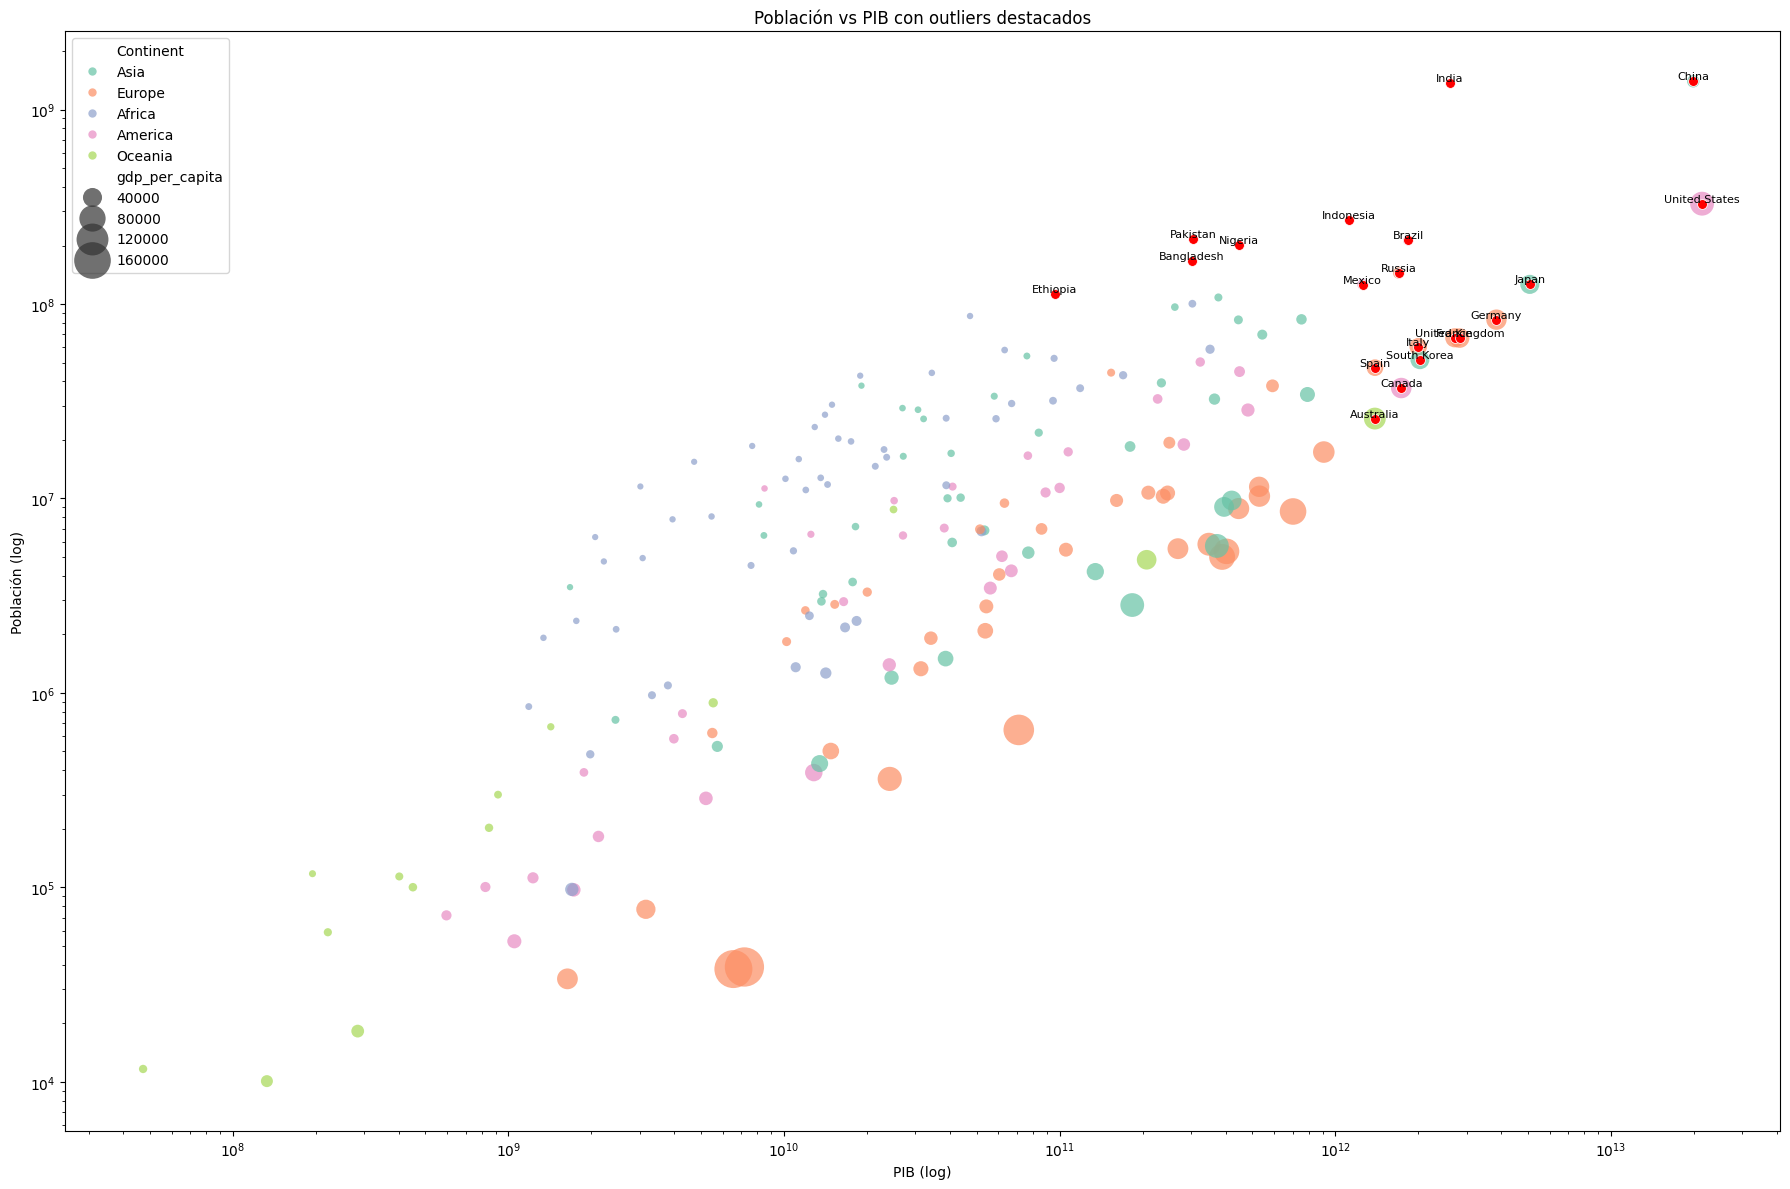

In [39]:
cols_4 = ['Population', 'GDP']

fig, ax = plt.subplots(figsize=(18,12))

sns.scatterplot(
    data=df_extra,
    x='GDP', y='Population',
    palette='Set2',
    hue='Continent',
    size='gdp_per_capita', sizes=(20,800),
    alpha=0.7, linewidth=0, ax=ax
)

# Obtener outliers extremos
paises_extremos = get_outliers(df_extra, cols_4, 3)
df_extremos = df_extra[paises_extremos]

# Países outliers
sns.scatterplot(
    data=df_extremos,
    x='GDP', y='Population',
    color='red',
    # edgecolor='black',
    s=50, marker='o',
    ax=ax, legend=False
)

# Anotar nombre sobre cada outlier
for _, row in df_extremos.iterrows():
    ax.text(
        row['GDP'], row['Population'],
        row['Country'],
        fontsize=8,
        # fontweight='bold',
        ha='center', va='bottom'
    )

ax.set(
       xscale='log',
       yscale='log',
       xlabel='PIB (log)',
       ylabel='Población (log)',
       title='Población vs PIB con outliers destacados')
plt.tight_layout()
plt.show()

Respecto al gráfico:

- Para poder visualizar los países y sus continentes se utiliza la librería country_converter. En el gráfico se identifican los continentes con diferentes colores
- Se incluye también en el gráfico el PIB per capita donde es identificado con las dimensiones del círculo que señala cada país
- Se utilizó escala logarítmica para poder mostrar todos los paises y evitar el efecto de los países como China, India y Estados Unidos que tienen una gran cantidad de población y PIB (outliers)
- Se incluye en el gráfico el nombre de los países considerados outliers

## 7. Otros datos
Escoge otro par de datos, límpialos, prepáralos y analiza su posible relación. Justifica utilizando las herramientas vistas y gráficos adecuados.

---

Para este análisis se utilizará el par de variables Co2-Emissions y GDP que tiene 0.92 de correlación. La correlación es directa y se puede concluir que los países con un PIB grande genran mayores emisiones de Co2, probablemente debido a que un mayor PIB indica mayor producción de productos y necesidad de energía lo que genera emisiones de Co2.

## 7.1 Ouliers

Para los outliers primero se utilizará el gráfico boxplot para identificar la existencia de estos valores atípicos:

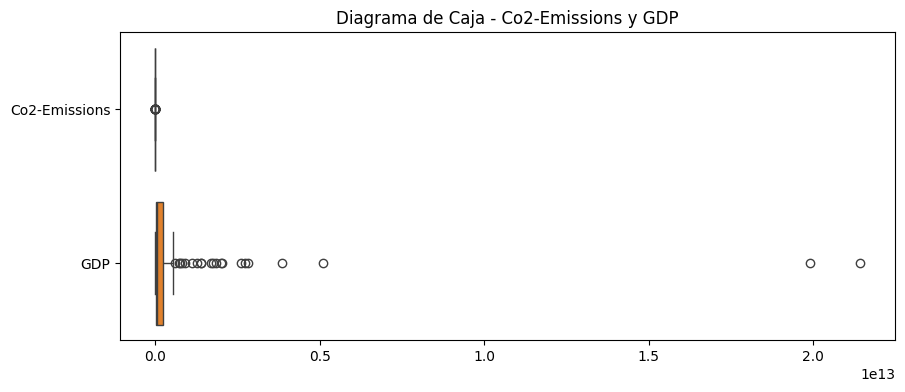

In [40]:
cols_4 = ['Co2-Emissions', 'GDP']
plt.figure(figsize=(10,4))
sns.boxplot(data=df[cols_4], orient='h')
plt.title("Diagrama de Caja - Co2-Emissions y GDP")
plt.show()

Según el gráfico existen muchos outliers en ambas variables. Para tratar con estos outliers se pretende utilizar una normalización de los datos y luego serán eliminados.

In [41]:
df_normalizado = escalado_robusto(df, cols_4)

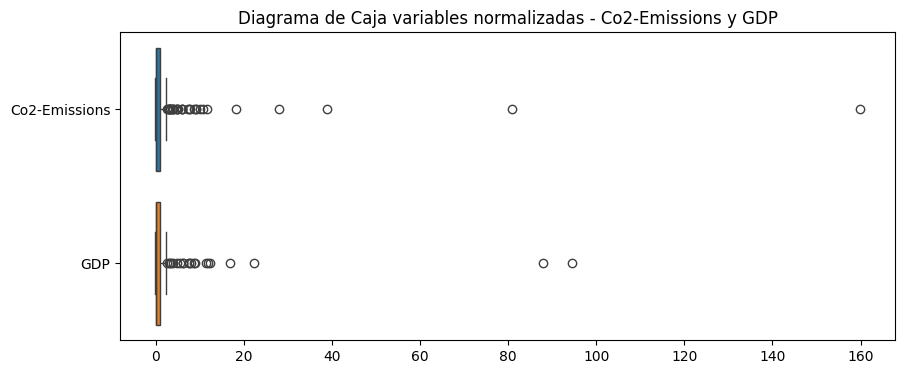

In [42]:
plt.figure(figsize=(10,4))
sns.boxplot(data=df_normalizado[cols_4], orient='h')
plt.title("Diagrama de Caja variables normalizadas - Co2-Emissions y GDP")
plt.show()

In [43]:
indices_outliers = get_outliers(df_normalizado, cols_4)
df_norm_sin_outliers = df_normalizado[~indices_outliers].copy()
df_norm_solo_outliers = df_normalizado[indices_outliers]

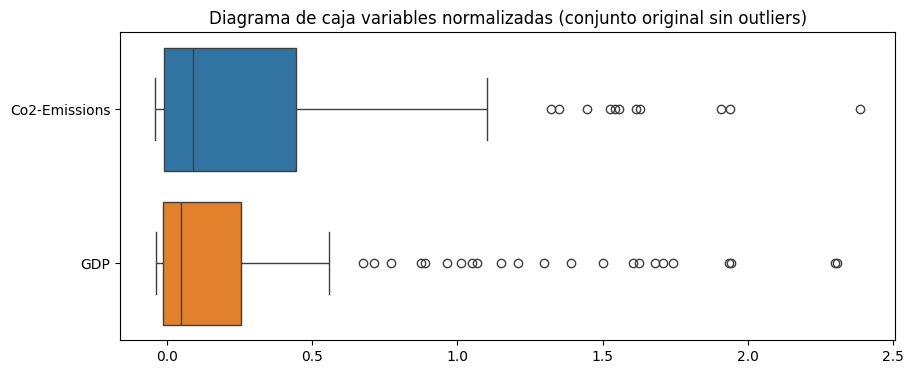

In [44]:
plt.figure(figsize=(10,4))
sns.boxplot(data=df_norm_sin_outliers[cols_4], orient='h')
plt.title("Diagrama de caja variables normalizadas (conjunto original sin outliers)")
plt.show()

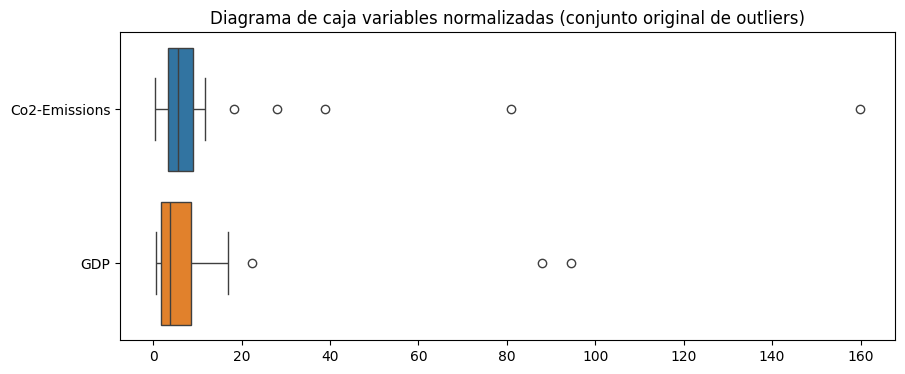

In [45]:
plt.figure(figsize=(10,4))
sns.boxplot(data=df_norm_solo_outliers[cols_4], orient='h')
plt.title("Diagrama de caja variables normalizadas (conjunto original de outliers)")
plt.show()

## 7.2 Valores Nulos

In [46]:
# Para determinar si se debe imputar o amputar los datos faltantes se obtiene el porcentaje de nulos por columna
df_norm_sin_outliers[cols_4].apply(lambda x: sum(x.isnull()), axis=0).sort_values(ascending=False) / len(df) * 100

,0
Co2-Emissions,3.61
GDP,1.03


Datos estadísticos antes de la imputación:

In [47]:
df_norm_sin_outliers[cols_4].describe()

,Co2-Emissions,GDP
count,153.00,158.00
mean,0.31,0.27
std,0.48,0.50
min,-0.04,-0.04
25%,-0.01,-0.01
50%,0.09,0.05
75%,0.44,0.25
max,2.39,2.31


Imputación y nuevos datos estadísticos:

In [48]:
df_norm_sin_outliers[cols_4] = imp_num.fit_transform(df_norm_sin_outliers[cols_4]) # Se imputa la media
df_norm_sin_outliers[cols_4].describe()

,Co2-Emissions,GDP
count,160.00,160.00
mean,0.30,0.27
std,0.47,0.50
min,-0.04,-0.04
25%,-0.01,-0.01
50%,0.09,0.05
75%,0.42,0.25
max,2.39,2.31


Las estadísticas no cambiaron mayormente (solo una centésima en algunos valores).